In [1]:
from glob import glob
import geopandas as gpd
import numpy as np
import logging
import matplotlib.pyplot as plt
from pathlib import Path

from multiview_prediction_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_prediction_toolkit.meshes import TexturedPhotogrammetryMesh

/ofo-share/repos-david/conda/envs/MVPT-jupyter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set values for constants
All edits should be able to be made below

In [2]:
SHORT_NAME = "delta"
LONG_NAME = "DeltaB"

GEO_FILENAME = "/ofo-share/str-disp_drone-data-partial/cross-site/crowns-w-field-labels/crowns_drone_w_field_data.gpkg"
UPDATED_GEO_FILNAME = "/ofo-share/repos-david/semantic-mesh-pytorch3d/data/species-class-seed-kernel/crowns_drone_w_field_data.geojson"

MESH_FILENAME = glob(f"/ofo-share/repos-david/semantic-mesh-pytorch3d/data/species-class-seed-kernel/metashape_exports/{LONG_NAME}*_w-mesh_exports/{LONG_NAME}*_w-mesh.ply")[0]
CAMERA_FILENAME = glob(f"/ofo-share/repos-david/semantic-mesh-pytorch3d/data/species-class-seed-kernel/metashape_exports/{LONG_NAME}*_w-mesh_exports/{LONG_NAME}*_w-mesh.xml")[0]

DEM_FILE = f"/ofo-share/str-disp_drone-data-partial/cross-site/dtms/photogrammetry/{SHORT_NAME}.tif"
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{LONG_NAME}/{LONG_NAME}_120m/"

DOWNSAMPLED_MESH_FILENAME = f"/ofo-share/repos-david/semantic-mesh-pytorch3d/data/species-class-seed-kernel/intermediate_meshes/{SHORT_NAME}_downsampled.ply" 
LABELED_MESH_FILENAME = f"/ofo-share/repos-david/semantic-mesh-pytorch3d/data/species-class-seed-kernel/intermediate_meshes/{SHORT_NAME}_labeled.ply" 

HEIGHT_ABOVE_GROUND_THRESH = 2
MESH_DOWNSAMPLE_TARGET = 0.25
RENDER_IMAGE_SCALE = 0.25
BUFFER_RADIUS_METER = 50

RECOMPUTE_CACHED_MESHES = False

# Geospatial processing

Preprocess the geospatial data to be as expected. Here we set all trees that are marked as dead to the SNAG class

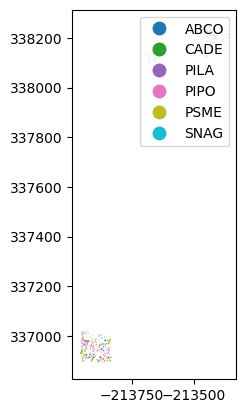

In [3]:
# Updated any trees marked as dead to the SNAG class
gdf = gpd.read_file(GEO_FILENAME)
dead_trees = np.logical_not(gdf["live_observed"].to_numpy().astype(bool))
gdf.loc[dead_trees, "species_observed"] = "SNAG"
gdf.to_file(UPDATED_GEO_FILNAME)

site_gdf = gdf.groupby("stem_map_name")
gdf.loc[gdf["fire"] == SHORT_NAME].plot("species_observed", legend=True)
plt.show()

# Load a mesh and downsample

In [4]:
if not Path(DOWNSAMPLED_MESH_FILENAME).is_file() or  RECOMPUTE_CACHED_MESHES:
    # Create a mesh to downsample
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=MESH_DOWNSAMPLE_TARGET,
    )
    # Save the downsampled mesh 
    mesh.save_mesh(DOWNSAMPLED_MESH_FILENAME, save_vert_texture=False)

# Load the mesh and read texture from geopolygon

In [5]:
if not Path(LABELED_MESH_FILENAME).is_file() or RECOMPUTE_CACHED_MESHES:
    mesh = TexturedPhotogrammetryMesh(
        DOWNSAMPLED_MESH_FILENAME,
        texture=UPDATED_GEO_FILNAME,
        texture_kwargs={"column_name": "species_observed"},
        transform_filename=CAMERA_FILENAME,
    )

    texture_faces = mesh.get_texture()
    ground_mask_verts = mesh.get_height_above_ground(DEM_file=DEM_FILE,threshold=HEIGHT_ABOVE_GROUND_THRESH)
    ground_mask_faces = mesh.vert_to_face_texture(ground_mask_verts)

    label_names = mesh.get_label_names()
    is_labeled = texture_faces[:,0] >= 0
    is_labeled_and_ground = np.logical_and(is_labeled, ground_mask_faces)

    # Set a new ground class only for ground that would otherwise be tree
    texture_faces[is_labeled_and_ground, 0] = len(label_names)
    mesh.set_texture(texture_faces)
    mesh.set_label_names(label_names.tolist() + ["GROUND"])
    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, 
        transform_filename=CAMERA_FILENAME
    )

# Load a set of cameras and downsample them to the region around annotations

In [6]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERA_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
# TODO consider how to do the same thing with a mesh
training_camera_set = camera_set.get_subset_near_geofile(
    UPDATED_GEO_FILNAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

Loading GPS data for camera set: 100%|██████████| 15600/15600 [02:59<00:00, 86.76it/s] 


# Show the mesh

/ofo-share/repos-david/conda/envs/MVPT-jupyter/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


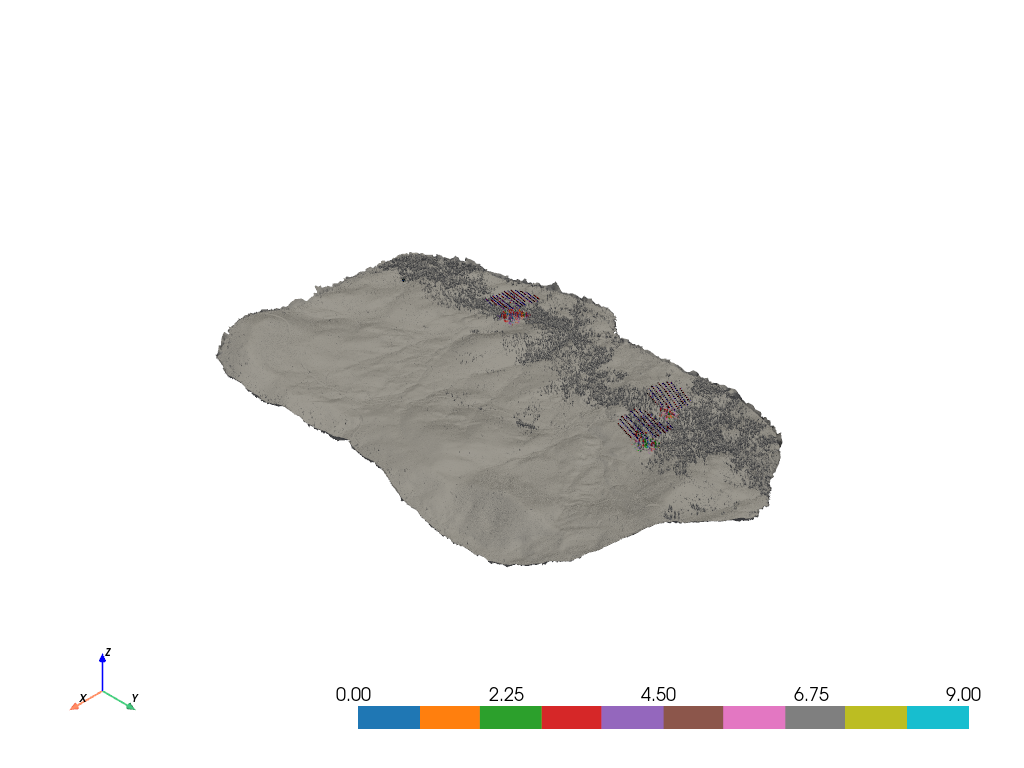

In [7]:
mesh.vis(
    mesh_kwargs={"cmap": "tab10", "clim": [0, 9]},
    camera_set=training_camera_set,
    force_xvfb=True
)

# Render the labels onto the images

In [8]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set, render_image_scale=RENDER_IMAGE_SCALE, save_native_resolution=True,
    render_folder=Path("renders", SHORT_NAME)

)

Saving renders:  10%|█         | 47/466 [04:05<35:43,  5.12s/it] /ofo-share/repos-david/semantic-mesh-pytorch3d/multiview_prediction_toolkit/meshes/meshes.py:1067: UserWarning: /ofo-share/repos-david/semantic-mesh-pytorch3d/vis/renders/delta/PART_01/102MEDIA/DJI_0425.png is a low contrast image
  skimage.io.imsave(output_filename, rendered)
Saving renders:  32%|███▏      | 147/466 [12:39<26:51,  5.05s/it]/ofo-share/repos-david/semantic-mesh-pytorch3d/multiview_prediction_toolkit/meshes/meshes.py:1067: UserWarning: /ofo-share/repos-david/semantic-mesh-pytorch3d/vis/renders/delta/PART_01/103MEDIA/DJI_0131.png is a low contrast image
  skimage.io.imsave(output_filename, rendered)
Saving renders:  38%|███▊      | 179/466 [15:21<24:18,  5.08s/it]/ofo-share/repos-david/semantic-mesh-pytorch3d/multiview_prediction_toolkit/meshes/meshes.py:1067: UserWarning: /ofo-share/repos-david/semantic-mesh-pytorch3d/vis/renders/delta/PART_01/102MEDIA/DJI_0998.png is a low contrast image
  skimage.io.imsav